<a href="https://colab.research.google.com/github/jdiazram/lecturasIIC3633-2021/blob/main/practicos/content_based_books_recommender_JDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://youtu.be/seMk0mF2JZE" target="_parent"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/YouTube_full-color_icon_%282017%29.svg/71px-YouTube_full-color_icon_%282017%29.svg.png" alt="Open In Colab"/></a>

# Práctico Content-based (Texto)

**Profesor:** Denis Parra

**Ayudantes:** Vladimir Araujo, Andrés Carvallo, Manuel Cartagena, Francisca Catán, Andres Villa 


En este proyecto trabajaremos con un modelo de recomendacion de libros de la página [Goodreads](http://www.goodreads.com). El modelo de recomendación de libros es un recomendador basado en contenido, donde se utilizan modelos de lenguage BERT y BERT-large para el cálculo de embeddings de los libros y luego similaridades de ítems. Luego, dependiendo de los libros con los que el usuario ha interactuado, se recomiendan los ítems más similares.

In [55]:
import numpy as np
import json
import requests
import heapq
import math
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import pandas as pd
import time 
import seaborn as sns

Descargamos datos que vienen previamente calculados: 
- transacciones/interacciones de cada usuario 
- transaciones para evaluar el modelo 
- embeddings de imágenes calculados con BERT  
- embeddings de imágenes calculados con BERT-large
- datos de libros con información de titulo, descripcion, año de publicacion, entre otros. 

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Q2wix9sRn7lEwPtnUDf70cewi9sAeVVW' -O books.tsv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qzt5Fxrf1KimlEqyKLNCc2UwxrOj6yAb' -O goodreads_bert_embeddings.npy
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Sls46iCyO__PU6d9FCO05loumYaooY_P' -O goodreads_bert_large_embeddings.npy
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BxNu7OwSz9zi20Ss120qG77BE3vNt4TG' -O goodreads_past_interactions.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1t5PIqci6UrWW1Qp8rtbaZz-GunnZu0zN' -O goodreads_test_interactions.json

--2021-09-20 19:05:05--  https://docs.google.com/uc?export=download&id=1Q2wix9sRn7lEwPtnUDf70cewi9sAeVVW
Resolving docs.google.com (docs.google.com)... 172.217.218.101, 172.217.218.139, 172.217.218.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.218.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iivo4n7r4rtkv7hdt0urpp26rrjoveq9/1632164700000/01180867749262413309/*/1Q2wix9sRn7lEwPtnUDf70cewi9sAeVVW?e=download [following]
--2021-09-20 19:05:10--  https://doc-0o-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iivo4n7r4rtkv7hdt0urpp26rrjoveq9/1632164700000/01180867749262413309/*/1Q2wix9sRn7lEwPtnUDf70cewi9sAeVVW?e=download
Resolving doc-0o-4g-docs.googleusercontent.com (doc-0o-4g-docs.googleusercontent.com)... 142.250.153.132, 2a00:1450:4013:c16::84
Connecting to doc-0o-4g-docs.googleusercontent.com (doc-0o

# Cargar datos adicionales

In [3]:
df_books = pd.read_csv('books.tsv', sep='\t')
df_books.head()


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,book_description
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,Winning will make you famous. Losing means cer...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,About three things I was absolutely positive.F...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,The unforgettable novel of a childhood in a sl...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,"THE GREAT GATSBY, F. Scott Fitzgerald’s third ..."


In [4]:
# diccionario con id del usuario y id de libros con los que ha interactuado en el pasado 
with open('goodreads_past_interactions.json') as f:
    user_interactions = json.load(f)

# diccionario con id del usuario y id de libros para testear el modelo     
with open('goodreads_test_interactions.json') as f:
    user_interactions_test = json.load(f)


In [5]:
# dict index 2 book id and vice-versa for recommendation 
idx2bookid = {i: id_ for i, id_ in enumerate(df_books.book_id)}
bookid2idx = {id_:i for i, id_ in enumerate(df_books.book_id)}

# Cargar características pre-entrenadas: BERT y BERT-large

En esta sección se trabajará con modelos pre-entrenados de modelos de lenguage BERT y BERT-large que convierten texto a embeddings. 

Bidirectional Encoder Representations from Transformers (BERT) es una técnica de NLP (Natural Language Processing) desarrollada por Google y publicada en 2018 por Jacob Devlin. 

Actualmente Google utiliza BERT para entender las consultas de los usuarios en su buscador. 

Tiene dos versiones: 
- **BERT:** 12 capas, 12 cabezales de atencion y 110 millones de parámetros. Genera vectores de 768 dimensiones 
- **BERT-large:** 24 capas, 16 cabezales de atencion y 340 millones de parámetros.  

![BERT y BERT-large](http://jalammar.github.io/images/bert-base-bert-large.png)

![BERT y BERT-large arquitectura](http://jalammar.github.io/images/bert-base-bert-large-encoders.png)

En este caso los textos que utilizaremos son los títulos de los libros con su descripción y compararemos los resultados de recomendación con BERT y BERT-large. Para efectos de este trabajo los vectores de características ya fueron entrenados y guardados en archivos numpy. A continuación son cargados en memoria.

Para mayores detalles sobre el modelo de lenguaje BERT se recomienda revisar el siguiente artículo:
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)


In [6]:
bert_featmat = np.load('goodreads_bert_embeddings.npy', allow_pickle=True)
bert_large_featmat = np.load('goodreads_bert_large_embeddings.npy', allow_pickle=True)

In [8]:
bert_featmat.shape

(4771, 768)

In [9]:
bert_large_featmat.shape

(4771, 1024)

### **Pregunta 1** 

Considerando que haremos un recomendador basado en contenidos ¿Por qué el uso de modelos de lenguage es una buena elección para este tipo de problema?

**Respuesta 1:** Debido que solo podemos usar contenido de los items no los item como tal, esto es: alguna descripción, año, etc y como los algoritmos no reconocen textos, estos se deben transformar a números o embeddings y para esta transformacion existen los modelos pre-entrenados, como BERT, para resolver esta tarea.

# Probamos con BERT y BERT-large reduciendo dimensionalidad con PCA-20

Una vez calculado (o cargado) los vectores característicos de cada libro a partir de su titulo y descripción, reducimos dimensionalidad. Probaremos con BERT y BERT-large para comparar los resultados de ambos en recomendación basada en contenido. 


In [10]:
# Project into a 20 PCA feature space
pca20_bert_featmat = PCA(n_components=20).fit_transform(bert_featmat)
pca20_bert_large_featmat = PCA(n_components=20).fit_transform(bert_large_featmat)

In [11]:
pca20_bert_featmat.shape

(4771, 20)

In [12]:
pca20_bert_large_featmat.shape

(4771, 20)

### **Pregunta 2**

Comente por qué se utiliza PCA para reducir la dimensión de cada vector característico. ¿Qué sucede con la pérdida de información en la reducción de dimensionalidad?

**Respuesta 2:** Se realiza reducción de dimensionalidad para que el cálculo de la similaridad sea los más eficiente posible y se espera que la pérdida de información no influya en los resultados ya que se mantiene la varianza de los datos.

# Similar document retrieval 

En esta sección utilizaremos los vectores cargados para hacer un sistema de recuperación o búsqueda de información, para diferentes métricas de distancia.

Buscamos libros similares de acuerdo a la representación vectorial (BERT) de su título y descripción. 


In [13]:
# format results 
pd.options.display.max_colwidth = 50
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# Find similar images by image id
def find_similar_books(embedding, query_id=None, metric='euclidean', topk=10):
    
    n = embedding.shape[0]
    
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = idx2bookid[query_i]
    
    else:
        query_i = bookid2idx[query_id]
        
    
    distances = pairwise_distances(embedding[query_i].reshape(1,-1), embedding, metric=metric)
    heap = []
    for i in range(n):            
        if len(heap) < topk:
            heapq.heappush(heap, (-distances[0][i], i))
        else:
            heapq.heappushpop(heap, (-distances[0][i], i))

    heap.sort(reverse=True)
    rec_ids = [idx2bookid[i] for _,i in heap]
    
    return rec_ids

## Usando BERT 

In [23]:
# libros similares al libro de id 41865 (Twilight) utilizando distancia euclideana. se puede cambiar a "cosine" 
similar_books = find_similar_books(bert_featmat, query_id = 41865, metric = 'cosine', topk=10 )
similar_books

[41865,
 7617119,
 8130839,
 7896345,
 15799166,
 6933876,
 6455256,
 9635495,
 395871,
 20797535]

In [24]:
df_books[df_books.book_id.isin(similar_books)][['book_id', 'original_title', 'book_description', 'authors']]

,book_id,original_title,book_description,authors
2,41865,Twilight,"About three things I was absolutely positive.First, Edward was a vampire.Second, there was a part of him—and I didn't know how dominant that part might be—that thirsted for my blood.And third, I was unconditionally and irrevocably in love with him.In the first book of the Twilight Saga, internationally bestselling author Stephenie Meyer introduces Bella Swan and Edward Cullen, a pair of star-crossed lovers whose forbidden relationship ripens against the backdrop of small-town suspicion and a mysterious coven of vampires. This is a love story with bite.",Stephenie Meyer
1383,395871,The Awakening and the Struggle,"This book has Alternate Cover Editions for this ISBN [ACE]\nACE #1\nA DEADLY LOVE TRIANGLEElena: the golden girl, the leader, the one who can have any boy she wants.Stefan: brooding and myterious, he seems to be the only one who can resist Elena, even as he struggles to protect her from the horrors that haunt his past.Damon: sexy, dangerous, and driven by an urge for revenge against Stefan, the brother who betrayed him. Determined to have Elena, he'd kill to possess her.Collected here in one volume for the first time, volumes one and two of The Vampire Diaries, the tale of two vampire brothers and the beautiful girl torn between them.",L.J. Smith
1447,15799166,"Release Me (Stark Trilogy, #1)","For fans of Fifty Shades of Grey and Bared to You comes an erotic, emotionally charged romance between a powerful man who’s never heard “no” and a fiery woman who says “yes” on her own terms. He was the one man I couldn’t avoid. And the one man I couldn’t resist. Damien Stark could have his way with any woman. He was sexy, confident, and commanding: Anything he wanted, he got. And what he wanted was me.Our attraction was unmistakable, almost beyond control, but as much as I ached to be his, I feared the pressures of his demands. Submitting to Damien meant I had to bare the darkest truth about my past—and risk breaking us apart.But Damien was haunted, too. And as our passion came to obsess us both, his secrets threatened to destroy him—and us—forever.Release Me is an erotic romance intended for mature audiences.",J. Kenner
2103,7896345,The Gathering,"Sixteen-year-old Maya is just an ordinary teen in an ordinary town. Sure, she doesn't know much about her background - the only thing she really has to cling to is an odd paw-print birthmark on her hip - but she never really put much thought into who her parents were or how she ended up with her adopted parents in this tiny medical-research community on Vancouver Island.Until now.Strange things have been happening in this claustrophobic town - from the mountain lions that have been approaching Maya to her best friend's hidden talent for ""feeling"" out people and situations, to the sexy new bad boy who makes Maya feel...different. Combine that with a few unexplained deaths and a mystery involving Maya's biological parents and it's easy to suspect that this town might have more than its share of skeletons in its closet.In THE GATHERING, New York Times best-selling author Kelley Armstrong brings all the supernatural thrills from her wildly successful Darkest Powers series to Darkness Rising, her scorching hot new trilogy.",Kelley Armstrong
3097,9635495,Fallen,"There's no police training stronger than a cop's instinct. Faith Mitchell's mother isn't answering her phone. Her front door is open. There's a bloodstain above the knob. Her infant daughter is hidden in a shed behind the house. All that the Georgia Bureau of Investigations taught Faith Mitchell goes out the window when she charges into her mother's house, gun drawn. She sees a man dead in the laundry room. She sees a hostage situation in the bedroom. What she doesn't see is her mother. . . . """"You know what we're here for. Hand it over, and we'll let her go."""" When the hostage situation turns deadly, Faith is left with too many questions, not enough answers. T

## Usando BERT reducidos con PCA 

In [25]:
# libros similares al libro de id 41865 (Twilight) utilizando distancia euclideana. se puede cambiar a "cosine" 
similar_books = find_similar_books(pca20_bert_featmat, query_id = 41865, metric = 'cosine', topk=10 )
similar_books

[41865,
 13522285,
 5776788,
 8130839,
 18080889,
 6485421,
 15813668,
 7617119,
 1295102,
 9975679]

In [26]:
df_books[df_books.book_id.isin(similar_books)][['book_id', 'original_title', 'book_description', 'authors']]

,book_id,original_title,book_description,authors
2,41865,Twilight,"About three things I was absolutely positive.First, Edward was a vampire.Second, there was a part of him—and I didn't know how dominant that part might be—that thirsted for my blood.And third, I was unconditionally and irrevocably in love with him.In the first book of the Twilight Saga, internationally bestselling author Stephenie Meyer introduces Bella Swan and Edward Cullen, a pair of star-crossed lovers whose forbidden relationship ripens against the backdrop of small-town suspicion and a mysterious coven of vampires. This is a love story with bite.",Stephenie Meyer
723,1295102,Lock and Key,"Ruby, where is your mother? Ruby knows that the game is up. For the past few months, she's been on her own in the yellow house, managing somehow, knowing that her mother will probably never return. That's how she comes to live with Cora, the sister she hasn't seen in ten years, and Cora's husband Jamie, whose down-to-earth demeanor makes it hard for Ruby to believe he founded the most popular networking Web site around. A luxurious house, fancy private school, a new wardrobe, the promise of college and a future; it's a dream come true. So why is Ruby such a reluctant Cinderella, wary and defensive? And why is Nate, the genial boy next door with some secrets of his own, unable to accept the help that Ruby is just learning to give? Best-selling author Sarah Dessen explores the heart of a gutsy, complex girl dealing with unforeseen circumstances and learning to trust again.",Sarah Dessen
1355,6485421,The Mortal Instruments Boxed Set: City of Bones; City of Ashes; City of Glass,"In City of Bones, fifteen-year-old Clary Fray is introduced to the world of the Shadowhunters, a secret cadre of warriors dedicated to driving demons out of our world. And she's introduced with a vengeance, when Clary's mother disappears and Clary herself is almost killed by a grotesque monster sent by the evil and powerful Shadowhunter, Valentine. How could a mere human survive such an attack. In the second novel, City of Ashes, Clary just wants her life to go back to normal--but that turns out to be impossible. For one thing, her mother is still in the hospital, in a mysterious coma. For another, she and her newfound brother Jace have fallen under a cloud of suspicion now that the Shadowhunter world knows that Valentine is still alive--and that Jace and Clary are his son and daughter. Then Clary's best friend Simon is turned into a vampire and kidnapped by Valentine, who intends to sacrifice him as part of a bloody ritual that will make the Mortal Instruments Valentine's forever. In book three, City of Glass, Clary has to use all her ingenuity and newfound magical skills to get herself to the Glass City in Idris, the secretive Shadowhunters' home country, where she is forbidden to go--for it is only there that she can find the cure to the enchanted sleeping sickness to which her mother has succumbed. When Valentine attacks the city and destroys the demon towers, Clary and her allies are all that stand between him and the total annihilation of all Shadowhunters. Love is a mortal sin and the past tangles inextricably with the present as Clary and Jace face down their father in the final installment of the Mortal Instruments series. About the AuthorCassandra Clare made her fiction debut with The Mortal Instruments series, which has been on many bestseller lists.",Cassandra Clare
2044,13522285,"Severed Heads, Broken Hearts","Golden boy Ezra Faulkner believes everyone has a tragedy waiting for them—a single encounter after which everything that really matters will happen. His particular tragedy waited until he was primed to lose it all: in one spectacular night, a reckless driver shatters Ezra’s knee, his athletic career, and his social life.No longer a front-runner for Homecoming King, Ezra finds himself at the table of misfits, where he encounters new girl Cassidy Thorpe. Cassidy is unlike anyone Ezra

## Usando BERT-large

In [27]:
# libros similares al libro de id 41865 (Twilight) utilizando distancia euclideana. se puede cambiar a "cosine" 
similar_books = find_similar_books(bert_large_featmat, query_id = 41865, metric = 'cosine', topk=10 )
similar_books

[41865,
 22611920,
 6303733,
 15799166,
 18594594,
 17675462,
 454856,
 13568619,
 13188676,
 22021611]

In [28]:
df_books[df_books.book_id.isin(similar_books)][['book_id', 'original_title', 'book_description', 'authors']]

,book_id,original_title,book_description,authors
2,41865,Twilight,"About three things I was absolutely positive.First, Edward was a vampire.Second, there was a part of him—and I didn't know how dominant that part might be—that thirsted for my blood.And third, I was unconditionally and irrevocably in love with him.In the first book of the Twilight Saga, internationally bestselling author Stephenie Meyer introduces Bella Swan and Edward Cullen, a pair of star-crossed lovers whose forbidden relationship ripens against the backdrop of small-town suspicion and a mysterious coven of vampires. This is a love story with bite.",Stephenie Meyer
794,17675462,The Raven Boys,"“There are only two reasons a non-seer would see a spirit on St. Mark’s Eve,” Neeve said. “Either you’re his true love . . . or you killed him.”It is freezing in the churchyard, even before the dead arrive.Every year, Blue Sargent stands next to her clairvoyant mother as the soon-to-be dead walk past. Blue herself never sees them—not until this year, when a boy emerges from the dark and speaks directly to her.His name is Gansey, and Blue soon discovers that he is a rich student at Aglionby, the local private school. Blue has a policy of staying away from Aglionby boys. Known as Raven Boys, they can only mean trouble.But Blue is drawn to Gansey, in a way she can’t entirely explain. He has it all—family money, good looks, devoted friends—but he’s looking for much more than that. He is on a quest that has encompassed three other Raven Boys: Adam, the scholarship student who resents all the privilege around him; Ronan, the fierce soul who ranges from anger to despair; and Noah, the taciturn watcher of the four, who notices many things but says very little.For as long as she can remember, Blue has been warned that she will cause her true love to die. She never thought this would be a problem. But now, as her life becomes caught up in the strange and sinister world of the Raven Boys, she’s not so sure anymore.From Maggie Stiefvater, the bestselling and acclaimed author of the Shiver trilogy and The Scorpio Races, comes a spellbinding new series where the inevitability of death and the nature of love lead us to a place we’ve never been before.",Maggie Stiefvater
1296,13188676,"Ignite Me (Shatter Me, #3)","The heart-stopping conclusion to the New York Times bestselling Shatter Me series, which Ransom Riggs, bestselling author of Miss Peregrine’s Home for Peculiar Children, called “a thrilling, high-stakes saga of self-discovery and forbidden love.”With Omega Point destroyed, Juliette doesn’t know if the rebels, her friends, or even Adam are alive. But that won’t keep her from trying to take down The Reestablishment once and for all. Now she must rely on Warner, the handsome commander of Sector 45. The one person she never thought she could trust. The same person who saved her life. He promises to help Juliette master her powers and save their dying world . . . but that’s not all he wants with her.The Shatter Me series is perfect for fans who crave action-packed young adult novels with tantalizing romance like Divergent by Veronica Roth, The Hunger Games by Suzanne Collins, and Legend by Marie Lu. Tahereh Mafi has created a captivating and original story that combines the best of dystopian and paranormal, and was praised by Publishers Weekly as “a gripping read from an author who’s not afraid to take risks.” Now this final book brings the series to a shocking and satisfying end.",Tahereh Mafi
1409,454856,Look Me in the Eye: My Life with Asperger's,"Ever since he was small, John Robison had longed to connect with other people, but by the time he was a teenager, his odd habits—an inclination to blurt out non sequiturs, avoid eye contact, dismantle radios, and dig five-foot holes (and stick his younger brother in them)—had earned him the label “social deviant.” No guidance came from his mother, who conversed with light fixtures, or his father, who spent evenings pickling himself 

## Usando BERT-large reducidos con PCA 

In [29]:
# libros similares al libro de id 41865 (Twilight) utilizando distancia euclideana. se puede cambiar a "cosine" 
similar_books = find_similar_books(pca20_bert_large_featmat, query_id = 41865, metric = 'cosine', topk=10 )
similar_books

[41865,
 22611920,
 15799166,
 13522957,
 18126198,
 17623975,
 6303733,
 18594594,
 13188676,
 17411703]

In [30]:
df_books[df_books.book_id.isin(similar_books)][['book_id', 'original_title', 'book_description', 'authors']]

,book_id,original_title,book_description,authors
2,41865,Twilight,"About three things I was absolutely positive.First, Edward was a vampire.Second, there was a part of him—and I didn't know how dominant that part might be—that thirsted for my blood.And third, I was unconditionally and irrevocably in love with him.In the first book of the Twilight Saga, internationally bestselling author Stephenie Meyer introduces Bella Swan and Edward Cullen, a pair of star-crossed lovers whose forbidden relationship ripens against the backdrop of small-town suspicion and a mysterious coven of vampires. This is a love story with bite.",Stephenie Meyer
885,18126198,Four: A Divergent Collection,"Two years before Beatrice Prior made her choice, the sixteen-year-old son of Abnegation’s faction leader did the same. Tobias’s transfer to Dauntless is a chance to begin again. Here, he will not be called the name his parents gave him. Here, he will not let fear turn him into a cowering child.Newly christened “Four,” he discovers during initiation that he will succeed in Dauntless. Initiation is only the beginning, though; Four must claim his place in the Dauntless hierarchy. His decisions will affect future initiates as well as uncover secrets that could threaten his own future—and the future of the entire faction system.Two years later, Four is poised to take action, but the course is still unclear. The first new initiate who jumps into the net might change all that. With her, the way to righting their world might become clear. With her, it might become possible to be Tobias once again.From #1 New York Times bestselling author Veronica Roth comes a companion volume to the worldwide bestselling DIVERGENT series, told from the per-spective of the immensely popular character Tobias. The four pieces included here—THE TRANSFER, THE INITIATE, THE SON, and THE TRAITOR—plus three additional exclusive scenes, give readers an electrifying glimpse into the history and heart of Tobias, and set the stage for the epic saga of the DIVERGENT trilogy.",Veronica Roth
1296,13188676,"Ignite Me (Shatter Me, #3)","The heart-stopping conclusion to the New York Times bestselling Shatter Me series, which Ransom Riggs, bestselling author of Miss Peregrine’s Home for Peculiar Children, called “a thrilling, high-stakes saga of self-discovery and forbidden love.”With Omega Point destroyed, Juliette doesn’t know if the rebels, her friends, or even Adam are alive. But that won’t keep her from trying to take down The Reestablishment once and for all. Now she must rely on Warner, the handsome commander of Sector 45. The one person she never thought she could trust. The same person who saved her life. He promises to help Juliette master her powers and save their dying world . . . but that’s not all he wants with her.The Shatter Me series is perfect for fans who crave action-packed young adult novels with tantalizing romance like Divergent by Veronica Roth, The Hunger Games by Suzanne Collins, and Legend by Marie Lu. Tahereh Mafi has created a captivating and original story that combines the best of dystopian and paranormal, and was praised by Publishers Weekly as “a gripping read from an author who’s not afraid to take risks.” Now this final book brings the series to a shocking and satisfying end.",Tahereh Mafi
1416,17623975,Just One Day,"From the New York Times bestselling author of If I Stay Allyson Healey's life is exactly like her suitcase—packed, planned, ordered. Then on the last day of her three-week post-graduation European tour, she meets Willem. A free-spirited, roving actor, Willem is everything she’s not, and when he invites her to abandon her plans and come to Paris with him, Allyson says yes. This uncharacteristic decision leads to a day of risk and romance, liberation and intimacy: 24 hours that will transform Allyson’s life.A book about love, heartbreak, travel, identity, and the “accidents” of fate, Just One Day shows us how sometimes in order to get found, you first 

### Pregunta 3: 
Comente los resultados obtenidos, en cuanto a modelo de lenguaje, reduccion de dimensionalidad y métrica de distancia utilizada. 


**Respuesta 3:** Se observa que en todos los resultados los libros similares son similares a Twilight y en todas ellas aparece como primera opción (muy buen resultado de similaridad) e independiente de que se haya reducido la dimensionalidad para todos los casos a 20 features, sigue siendo muy buenos resultados. Y tambien se utilizó la metrica de cosine, obteniendo otros resultados, pero mantiniendo la primera opcion como Twilight.

# Recomendaciones 

In [31]:
# format results 
pd.options.display.max_colwidth = 50
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


## Función para obtener recomendacion para cada usuario 

In [32]:
def recommend(embedding, user_id=None, topk=10, metric='cosine'):
    
    #print("user_id = ", user_id)
    
    user_id = str(user_id)
    
    #Calculate distance metrics
    trx = user_interactions[user_id]
    n = embedding.shape[0]
    distances = 1e9
    
    # recorremos transacciones pasadas del usuario 
    for t in trx:
        query_i = bookid2idx[t]
        
        # recomendamos items más cercanos a items con los que interactuó el usuario
        distances = np.minimum(distances, pairwise_distances(
                embedding[query_i].reshape(1,-1), embedding, metric=metric).reshape(-1))

    #Rank items de menor a mayor distancia (nos quedamos con los topk)
    trx_set = set(trx)
    heap = []
    for i in range(n):
        if idx2bookid[i] in trx_set:
            continue
        if len(heap) < topk:
            heapq.heappush(heap, (-distances[i], i))
        else:
            heapq.heappushpop(heap, (-distances[i], i))
    heap.sort(reverse=True)
    
    # utilizamos un heap para extraer los items ordenados de menor a mayor distancia 
    recommended_ids = [idx2bookid[i] for _,i in heap]
    
    # retornar los que el usuario no haya consumido 
    filtered_recommended_ids = []
    
    return recommended_ids

## generar recomendaciones para un usuario en particular

In [33]:
# recomendación para el usuario id = 49299 , utilizando bert con reduccion de dimensionalidad a 20 
user_id = '50101'
rec = recommend(pca20_bert_featmat, user_id=user_id, topk=15)
rec 

[49596,
 28703,
 7805,
 38500,
 2161733,
 26046,
 2120932,
 11250317,
 29800,
 228296,
 6050678,
 39031,
 25,
 296264,
 4162673]

## transacciones pasadas del usuario 

In [34]:
past_interactions = user_interactions[str(user_id)]

df_books[df_books['book_id'].isin(past_interactions)][['book_id', 'original_title', 'book_description', 'authors']]


,book_id,original_title,book_description,authors
1,3,Harry Potter and the Philosopher's Stone,"Harry Potter's life is miserable. His parents are dead and he's stuck with his heartless relatives, who force him to live in a tiny closet under the stairs. But his fortune changes when he receives a letter that tells him the truth about himself: he's a wizard. A mysterious visitor rescues him from his relatives and takes him to his new home, Hogwarts School of Witchcraft and Wizardry.After a lifetime of bottling up his magical powers, Harry finally feels like a normal kid. But even within the Wizarding community, he is special. He is the boy who lived: the only person to have ever survived a killing curse inflicted by the evil Lord Voldemort, who launched a brutal takeover of the Wizarding world, only to vanish after failing to kill Harry.Though Harry's first year at Hogwarts is the best of his life, not everything is perfect. There is a dangerous secret object hidden within the castle walls, and Harry believes it's his responsibility to prevent it from falling into evil hands. But doing so will bring him into contact with forces more terrifying than he ever could have imagined.Full of sympathetic characters, wildly imaginative situations, and countless exciting details, the first installment in the series assembles an unforgettable magical world and sets the stage for many high-stakes adventures to come.","J.K. Rowling, Mary GrandPré"
18,34,The Fellowship of the Ring,"One Ring to rule them all, One Ring to find them, One Ring to bring them all and in the darkeness bind themIn ancient times the Rings of Power were crafted by the Elven-smiths, and Sauron, The Dark Lord, forged the One Ring, filling it with his own power so that he could rule all others. But the One Ring was taken from him, and though he sought it throughout Middle-earth, it remained lost to him. After many ages it fell into the hands of Bilbo Baggins, as told in The Hobbit.In a sleepy village in the Shire, young Frodo Baggins finds himself faced with an immense task, as his elderly cousin Bilbo entrusts the Ring to his care. Frodo must leave his home and make a perilous journey across Middle-earth to the Cracks of Doom, there to destroy the Ring and foil the Dark Lord in his evil purpose.",J.R.R. Tolkien
23,6,Harry Potter and the Goblet of Fire,"Harry Potter is midway through both his training as a wizard and his coming of age. Harry wants to get away from the pernicious Dursleys and go to the International Quidditch Cup with Hermione, Ron, and the Weasleys. He wants to dream about Cho Chang, his crush (and maybe do more than dream). He wants to find out about the mysterious event that supposed to take place at Hogwarts this year, an event involving two other rival schools of magic, and a competition that hasn't happened for hundreds of years. He wants to be a normal, fourteen-year-old wizard. But unfortunately for Harry Potter, he's not normal - even by wizarding standards.And in his case, different can be deadly.-From the back cover","J.K. Rowling, Mary GrandPré"
50,11,The Hitchhiker's Guide to the Galaxy,"Seconds before the Earth is demolished to make way for a galactic freeway, Arthur Dent is plucked off the planet by his friend Ford Prefect, a researcher for the revised edition of The Hitchhiker's Guide to the Galaxy who, for the last fifteen years, has been posing as an out-of-work actor.Together this dynamic pair begin a journey through space aided by quotes from The Hitchhiker's Guide (""A towel is about the most massively useful thing an interstellar hitchhiker can have"") and a galaxy-full of fellow travelers: Zaphod Beeblebrox--the two-headed, three-armed ex-hippie and totally out-to-lunch president of the galaxy; Trillian, Zaphod's girlfriend (formally Tricia McMillan), whom Arthur tried to pick up at a cocktail party once upon a time zone; Marvin, a paranoid, brilliant, and chronically depressed robot; Veet Voojagig, a former graduate student who is obse

## información de recomendaciones 

In [35]:
df_books[df_books['book_id'].isin(rec)][['book_id', 'original_title', 'book_description', 'authors']]

,book_id,original_title,book_description,authors
149,2120932,The Battle of the Labyrinth,"Percy Jackson isn't expecting freshman orientation to be any fun. But when a mysterious mortal acquaintance appears at his potential new school, followed by demon cheerleaders, things quickly move from bad to worse.In this fourth installment of the blockbuster series, time is running out as war between the Olympians and the evil Titan lord Kronos draws near. Even the safe haven of Camp Half-Blood grows more vulnerable by the minute as Kronos's army prepares to invade its once impenetrable borders. To stop the invasion, Percy and his demigod friends must set out on a quest through the Labyrinth - a sprawling underground world with stunning surprises at every turn.",Rick Riordan
660,29800,"Scott Pilgrim, Volume 1: Scott Pilgrim's Precious Little Life","Scott Pilgrim's life is totally sweet. He's 23 years old, he's in a rockband, he's ""between jobs"" and he's dating a cute high school girl. Nothing could possibly go wrong, unless a seriously mind-blowing, dangerously fashionable, rollerblading delivery girl named Ramona Flowers starts cruising through his dreams and sailing by him at parties. Will Scott's awesome life get turned upside-down? Will he have to face Ramona's seven evil ex-boyfriends in battle? The short answer is yes. The long answer is Scott Pilgrim, Volume 1: Scott Pilgrim's Precious Little Life",Bryan Lee O'Malley
1026,228296,Rosemary's Baby,"Rosemary and Guy Woodhouse, an ordinary young couple, settle into a New York City apartment, unaware that the elderly neighbors and their bizarre group of friends have taken a disturbing interest in them. But by the time Rosemary discovers the horrifying truth, it may be far too late!",Ira Levin
1350,6050678,Leviathan,"Prince Aleksander, would-be heir to the Austro-Hungarian throne, is on the run. His own people have turned on him. His title is worthless. All he has is a battletorn war machine and a loyal crew of men.Deryn Sharp is a commoner, disguised as a boy in the British Air Service. She's a brilliant airman. But her secret is in constant danger of being discovered.With World War I brewing, Alek and Deryn's paths cross in the most unexpected way…taking them on a fantastical, around-the-world adventure that will change both their lives forever.",Scott Westerfeld
1404,2161733,Child 44,"In a country ruled by fear, no one is innocent.Stalin's Soviet Union is an official paradise, where citizens live free from crime and fear only one thing: the all-powerful state. Defending this system is idealistic security officer Leo Demidov, a war hero who believes in the iron fist of the law, but when a murderer starts to kill at will and Leo dares to investigate, the State's obedient servant finds himself demoted and exiled. Now, with only his wife at his side, Leo must fight to uncover shocking truths about a killer--and a country where ""crime"" doesn't exist.",Tom Rob Smith
1493,38500,Women,"Alternate cover for this ISBN can be found hereLow-life writer and unrepentant alcoholic Henry Chinaski was born to survive. After decades of slacking off at low-paying dead-end jobs, blowing his cash on booze and women, and scrimping by in flea-bitten apartments, Chinaski sees his poetic star rising at last. Now, at fifty, he is reveling in his sudden rock-star life, running three hundred hangovers a year, and maintaining a sex life that would cripple Casanova.With all of Bukowski's trademark humor and gritty, dark honesty, this 1978 follow-up to Post Office and Factotum is an uncompromising account of life on the edge.",Charles Bukowski
1501,25,Notes from a Big Country,"After living in Britain for two decades, Bill Bryson recently moved back to the United States with his English wife and four children (he had read somewhere that nearly 3 million Americans believed they had been abducted by aliens--as he later put it, ""it was clear my people needed me""). They were greeted by a new and improved America t

# evaluación de las recomendaciones con interacciones de testing 

In [36]:
# Métricas de evaluación 
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg


## Evaluación de recomendación con BERT

In [45]:
start = time.time()

mean_map_1 = 0.
mean_ndcg_1 = 0.

embeddings = pca20_bert_featmat
topk = 10 

for i, u in enumerate(user_interactions_test.keys()):
    
    print(i, end= '\r')
    
    rec = recommend(bert_featmat, user_id = u, topk=topk)
    rel_vector = [np.isin(user_interactions_test[u], rec, assume_unique=True).astype(int)]
    mean_map_1 += mean_average_precision(rel_vector)
    mean_ndcg_1 += ndcg_at_k(rel_vector, topk)

mean_map_1 /= len(user_interactions_test)
mean_ndcg_1 /= len(user_interactions_test)

time_taken_1 = time.time() - start


In [46]:
print('MAP ',mean_map_1)
print('ndcg@10' ,mean_ndcg_1)
print('tiempo de ejecucion {0:.2f} segs'.format(time_taken_1))


MAP  0.005180859080633007
ndcg@10 0.006154232604873147
tiempo de ejecucion 582.94 segs


## Evaluación de recomendación con BERT reducidos con PCA-20

In [47]:
start = time.time()

mean_map_2 = 0.
mean_ndcg_2 = 0.

embeddings = pca20_bert_featmat
topk = 10 

for i, u in enumerate(user_interactions_test.keys()):
    
    print(i, end= '\r')
    
    rec = recommend(pca20_bert_featmat, user_id = u, topk=topk)
    rel_vector = [np.isin(user_interactions_test[u], rec, assume_unique=True).astype(int)]
    mean_map_2 += mean_average_precision(rel_vector)
    mean_ndcg_2 += ndcg_at_k(rel_vector, topk)

mean_map_2 /= len(user_interactions_test)
mean_ndcg_2 /= len(user_interactions_test)

time_taken_2 = time.time() - start


In [48]:
print('MAP ',mean_map_2)
print('ndcg@10' ,mean_ndcg_2)
print('tiempo de ejecucion {0:.2f} segs'.format(time_taken_2))

MAP  0.005289709453236206
ndcg@10 0.006279829188646069
tiempo de ejecucion 91.93 segs


## Evaluación de recomendación con BERT-large

In [50]:
start = time.time()

mean_map_3 = 0.
mean_ndcg_3 = 0.

topk = 10 

for i, u in enumerate(user_interactions_test.keys()):
    
    print(i, end= '\r')
    
    rec = recommend(bert_large_featmat, user_id = u, topk=topk)
    rel_vector = [np.isin(user_interactions_test[u], rec, assume_unique=True).astype(int)]
    mean_map_3 += mean_average_precision(rel_vector)
    mean_ndcg_3 += ndcg_at_k(rel_vector, topk)

mean_map_3 /= len(user_interactions_test)
mean_ndcg_3 /= len(user_interactions_test)

time_taken_3 = time.time() - start

In [51]:
print('MAP ',mean_map_3)
print('ndcg@10' ,mean_ndcg_3)
print('tiempo de ejecucion {0:.2f} segs'.format(time_taken_3))

MAP  0.0040714225906388676
ndcg@10 0.00552624968600854
tiempo de ejecucion 646.65 segs


## Evaluación de recomendación con BERT-large reducidos con PCA-20

In [52]:
start = time.time()

mean_map_4 = 0.
mean_ndcg_4 = 0.

topk = 10 

for i, u in enumerate(user_interactions_test.keys()):
    
    print(i, end= '\r')
    
    rec = recommend(pca20_bert_large_featmat, user_id = u, topk=topk)
    rel_vector = [np.isin(user_interactions_test[u], rec, assume_unique=True).astype(int)]
    mean_map_4 += mean_average_precision(rel_vector)
    mean_ndcg_4 += ndcg_at_k(rel_vector, topk)

mean_map_4 /= len(user_interactions_test)
mean_ndcg_4 /= len(user_interactions_test)

time_taken_4 = time.time() - start


In [53]:
print('MAP ',mean_map_4)
print('ndcg@10' ,mean_ndcg_4)
print('tiempo de ejecucion {0:.2f} segs'.format(time_taken_4))

MAP  0.004309158981351898
ndcg@10 0.005149459934689776
tiempo de ejecucion 92.27 segs


### Pregunta 4: 
- Comente los resultados en términos de tiempo de ejecución y métricas de ranking para los 4 modelos. 

Text(0, 0.5, 'Valores de MAP y NDCG')

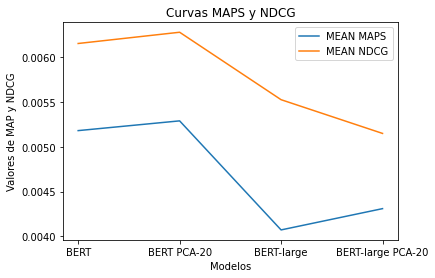

In [62]:
models = ["BERT","BERT PCA-20","BERT-large","BERT-large PCA-20"]
maps = [mean_map_1,mean_map_2,mean_map_3,mean_map_4]
ndcgs = [mean_ndcg_1,mean_ndcg_2,mean_ndcg_3,mean_ndcg_4]

sns.lineplot(x = models , y = maps, label = "MEAN MAPS")
sns.lineplot(x = models , y = ndcgs, label = "MEAN NDCG")
plt.title("Curvas MAPS y NDCG")
plt.xlabel("Modelos")
plt.ylabel("Valores de MAP y NDCG")

Text(0, 0.5, 'Valores de Tiempo de ejecución')

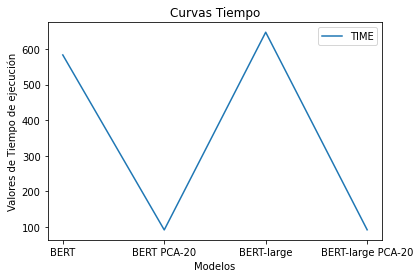

In [66]:
models = ["BERT","BERT PCA-20","BERT-large","BERT-large PCA-20"]
times = [time_taken_1,time_taken_2,time_taken_3,time_taken_4]

sns.lineplot(x = models , y = times, label = "TIME")
plt.title("Curvas Tiempo")
plt.xlabel("Modelos")
plt.ylabel("Valores de Tiempo de ejecución")

**Respuesta 4:** Se observa que BERT y BERT-Large son los que toman mayor cantidad de tiempo, y eso es debido a la cantidad de parámetros que cuenta cada uno de ellos. Además según las métricas aplicadas, los modelos que tienden a tener una mas baja MAP y NDCG son BERT-large y BERT PCA-20, contrario a los otros 2 modelos que tienen una mas alta MAP y NDCG.